In [25]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import corpora, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Word2Vec

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

SVM with Word2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        20
           2       0.45      1.00      0.62        43
           3       0.00      0.00      0.00        17

    accuracy                           0.45        96
   macro avg       0.11      0.25      0.15        96
weighted avg       0.20      0.45      0.28        96



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


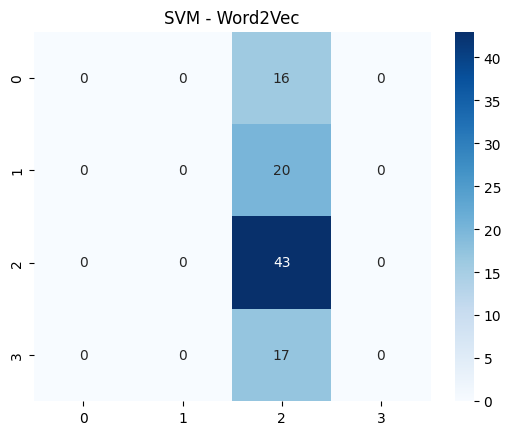


Random Forest with Word2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.12      0.15      0.13        20
           2       0.54      0.77      0.63        43
           3       0.40      0.12      0.18        17

    accuracy                           0.40        96
   macro avg       0.27      0.26      0.24        96
weighted avg       0.34      0.40      0.34        96



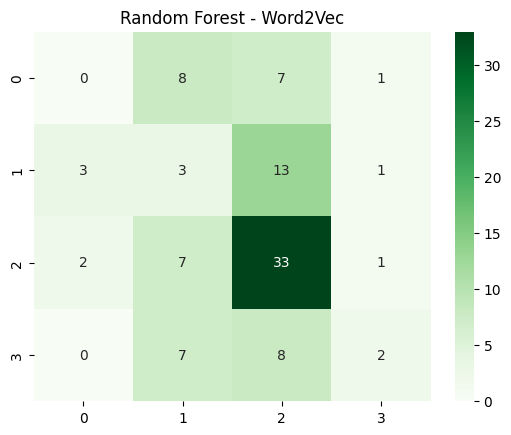

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Sentences misclassified by both classifiers:
Common Misclassified Sentence 1: After hacking state TV by replacing propaganda images with real ones they directly addressed Putin's "Against us you cannot win" and the soldiers on the front lines with a call to lay down their weapons. Today you can fight a war without firing a shot. Respect
-
Common Misclassified Sentence 2: If only we all showed more love and understanding maybe we would not need to fight wars with bombs and weapons.

As much as you can have a good Sunday, all our thoughts are with the Ukrainian people. 🙏❤️
#PACE #NoWar
#goodmorning #CanYaman
-
Common Misclassified Sentence 3: War in Ukraine: battle in the streets of Kiev. Zelensky's appeal: "Let's defend the capital, weapons are coming." | Live, video and photos #Ukraine #russia #w

In [22]:


nltk.download('punkt')

# Load dataset
data = pd.read_csv("/kaggle/input/filtered-and-translated-nlp/filr.csv")

# Extract relevant columns
texts = data["Translated"].astype(str).tolist()
labels = data["Label"].tolist()

# Tokenize sentences
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Train Word2Vec Model
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Function to get sentence embedding (mean of word vectors)
def get_sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Create sentence embeddings using Word2Vec
X_word2vec = np.array([get_sentence_vector(sentence, word2vec_model) for sentence in tokenized_texts])

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, labels, test_size=0.2, random_state=42)

# Train SVM and Random Forest models
svm_w2v = SVC(kernel='linear')
rf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)

svm_w2v.fit(X_train, y_train)
rf_w2v.fit(X_train, y_train)

# Predictions
y_pred_svm_w2v = svm_w2v.predict(X_test)
y_pred_rf_w2v = rf_w2v.predict(X_test)

# Evaluation: Word2Vec
print("\nSVM with Word2Vec Classification Report:")
print(classification_report(y_test, y_pred_svm_w2v))

# Confusion matrices
sns.heatmap(confusion_matrix(y_test, y_pred_svm_w2v), annot=True, fmt='d', cmap='Blues')
plt.title("SVM - Word2Vec")
plt.show()

print("\nRandom Forest with Word2Vec Classification Report:")
print(classification_report(y_test, y_pred_rf_w2v))

sns.heatmap(confusion_matrix(y_test, y_pred_rf_w2v), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Word2Vec")
plt.show()



nltk.download('averaged_perceptron_tagger')

# POS tagging of original sentences
pos_tagged_texts = [pos_tag(word_tokenize(text.lower())) for text in texts]

# Identify misclassified samples
misclassified_indices_svm = np.where(y_pred_svm != y_test)[0]
misclassified_indices_rf = np.where(y_pred_rf != y_test)[0]

misclassified_texts_svm = [texts[i] for i in misclassified_indices_svm]
misclassified_texts_rf = [texts[i] for i in misclassified_indices_rf]

misclassified_pos_svm = [pos_tagged_texts[i] for i in misclassified_indices_svm]
misclassified_pos_rf = [pos_tagged_texts[i] for i in misclassified_indices_rf]

# Identify sentences misclassified by both classifiers
common_misclassified_indices = set(misclassified_indices_svm) & set(misclassified_indices_rf)
common_misclassified_texts = [texts[i] for i in common_misclassified_indices]

print("Sentences misclassified by both classifiers:")
for idx, sentence in enumerate(common_misclassified_texts[:10]):  # Display top 10
    print(f"Common Misclassified Sentence {idx+1}: {sentence}")
    print("-")

# Suggesting changes to POS tagging for better classification
def suggest_pos_changes(sentence_tokens):
    """Suggest modifications to POS tagging to improve classification"""
    modified_tokens = []
    for word, tag in sentence_tokens:
        if tag in ["NN", "NNS"]:  # Nouns
            modified_tokens.append((word, "NN"))
        elif tag in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]:  # Verbs
            modified_tokens.append((word, "VB"))
        elif tag in ["JJ", "JJR", "JJS"]:  # Adjectives
            modified_tokens.append((word, "JJ"))
        else:
            modified_tokens.append((word, tag))
    return modified_tokens

# Applying suggested modifications
suggested_pos_svm = [suggest_pos_changes(pos) for pos in misclassified_pos_svm]
suggested_pos_rf = [suggest_pos_changes(pos) for pos in misclassified_pos_rf]

# Display suggested POS modifications
print("Suggested POS Tagging Modifications for SVM Misclassified Sentences:")
for idx, suggested in enumerate(suggested_pos_svm[:10]):  # Show top 10
    print(f"Modified SVM Misclassified Sentence {idx+1} POS Tags:", suggested)
    print("-")

print("Suggested POS Tagging Modifications for RF Misclassified Sentences:")
for idx, suggested in enumerate(suggested_pos_rf[:10]):  # Show top 10
    print(f"Modified RF Misclassified Sentence {idx+1} POS Tags:", suggested)
    print("-")


# Doc2Vec

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

SVM with Doc2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        20
           2       0.45      1.00      0.62        43
           3       0.00      0.00      0.00        17

    accuracy                           0.45        96
   macro avg       0.11      0.25      0.15        96
weighted avg       0.20      0.45      0.28        96



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


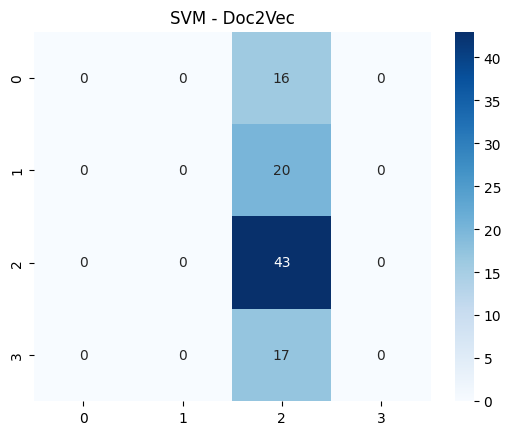


Random Forest with Doc2Vec Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.19      0.23        16
           1       0.27      0.20      0.23        20
           2       0.44      0.67      0.53        43
           3       0.40      0.12      0.18        17

    accuracy                           0.40        96
   macro avg       0.35      0.29      0.29        96
weighted avg       0.37      0.40      0.36        96



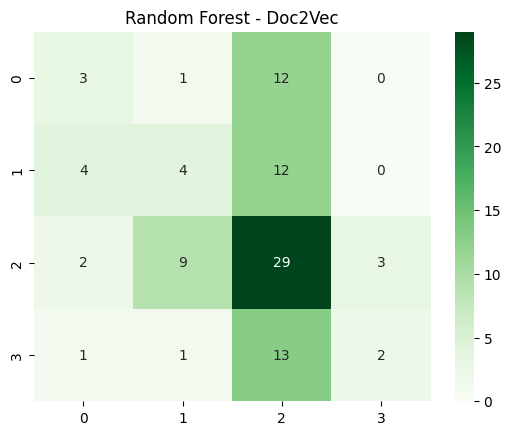

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
Sentences misclassified by both classifiers:
Common Misclassified Sentence 1: After hacking state TV by replacing propaganda images with real ones they directly addressed Putin's "Against us you cannot win" and the soldiers on the front lines with a call to lay down their weapons. Today you can fight a war without firing a shot. Respect
-
Common Misclassified Sentence 2: If only we all showed more love and understanding maybe we would not need to fight wars with bombs and weapons.

As much as you can have a good Sunday, all our thoughts are with the Ukrainian people. 🙏❤️
#PACE #NoWar
#goodmorning #CanYaman
-
Common Misclassified Sentence 3: War in Ukraine: battle in the streets of Kiev. Zelensky's appeal: "Let's defend the capital, weapons are coming." | Live, video and photos #Ukraine #russia #w

In [23]:


nltk.download('punkt')

# Load dataset
data = pd.read_csv("/kaggle/input/filtered-and-translated-nlp/filr.csv")

# Extract relevant columns
texts = data["Translated"].astype(str).tolist()
labels = data["Label"].tolist()

# Tokenize and tag sentences for Doc2Vec
tokenized_texts = [word_tokenize(text.lower()) for text in texts]
tagged_data = [TaggedDocument(words=sentence, tags=[str(i)]) for i, sentence in enumerate(tokenized_texts)]

# Train Doc2Vec Model
doc2vec_model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

# Create sentence embeddings using Doc2Vec
X_doc2vec = np.array([doc2vec_model.infer_vector(sentence) for sentence in tokenized_texts])

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_doc2vec, labels, test_size=0.2, random_state=42)

# Train SVM and Random Forest models
svm_d2v = SVC(kernel='linear')
rf_d2v = RandomForestClassifier(n_estimators=100, random_state=42)

svm_d2v.fit(X_train, y_train)
rf_d2v.fit(X_train, y_train)

# Predictions
y_pred_svm_d2v = svm_d2v.predict(X_test)
y_pred_rf_d2v = rf_d2v.predict(X_test)

# Evaluation: Doc2Vec
print("\nSVM with Doc2Vec Classification Report:")
print(classification_report(y_test, y_pred_svm_d2v))

# Confusion matrices
sns.heatmap(confusion_matrix(y_test, y_pred_svm_d2v), annot=True, fmt='d', cmap='Blues')
plt.title("SVM - Doc2Vec")
plt.show()

print("\nRandom Forest with Doc2Vec Classification Report:")
print(classification_report(y_test, y_pred_rf_d2v))


sns.heatmap(confusion_matrix(y_test, y_pred_rf_d2v), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest - Doc2Vec")
plt.show()


import nltk
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')

# POS tagging of original sentences
pos_tagged_texts = [pos_tag(word_tokenize(text.lower())) for text in texts]

# Identify misclassified samples
misclassified_indices_svm = np.where(y_pred_svm != y_test)[0]
misclassified_indices_rf = np.where(y_pred_rf != y_test)[0]

misclassified_texts_svm = [texts[i] for i in misclassified_indices_svm]
misclassified_texts_rf = [texts[i] for i in misclassified_indices_rf]

misclassified_pos_svm = [pos_tagged_texts[i] for i in misclassified_indices_svm]
misclassified_pos_rf = [pos_tagged_texts[i] for i in misclassified_indices_rf]

# Identify sentences misclassified by both classifiers
common_misclassified_indices = set(misclassified_indices_svm) & set(misclassified_indices_rf)
common_misclassified_texts = [texts[i] for i in common_misclassified_indices]

print("Sentences misclassified by both classifiers:")
for idx, sentence in enumerate(common_misclassified_texts[:10]):  # Display top 10
    print(f"Common Misclassified Sentence {idx+1}: {sentence}")
    print("-")

# Suggesting changes to POS tagging for better classification
def suggest_pos_changes(sentence_tokens):
    """Suggest modifications to POS tagging to improve classification"""
    modified_tokens = []
    for word, tag in sentence_tokens:
        if tag in ["NN", "NNS"]:  # Nouns
            modified_tokens.append((word, "NN"))
        elif tag in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]:  # Verbs
            modified_tokens.append((word, "VB"))
        elif tag in ["JJ", "JJR", "JJS"]:  # Adjectives
            modified_tokens.append((word, "JJ"))
        else:
            modified_tokens.append((word, tag))
    return modified_tokens

# Applying suggested modifications
suggested_pos_svm = [suggest_pos_changes(pos) for pos in misclassified_pos_svm]
suggested_pos_rf = [suggest_pos_changes(pos) for pos in misclassified_pos_rf]

# Display suggested POS modifications
print("Suggested POS Tagging Modifications for SVM Misclassified Sentences:")
for idx, suggested in enumerate(suggested_pos_svm[:10]):  # Show top 10
    print(f"Modified SVM Misclassified Sentence {idx+1} POS Tags:", suggested)
    print("-")

print("Suggested POS Tagging Modifications for RF Misclassified Sentences:")
for idx, suggested in enumerate(suggested_pos_rf[:10]):  # Show top 10
    print(f"Modified RF Misclassified Sentence {idx+1} POS Tags:", suggested)
    print("-")



# Glove

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        16
           1       0.57      0.40      0.47        20
           2       0.54      0.74      0.63        43
           3       0.57      0.24      0.33        17

    accuracy                           0.56        96
   macro avg       0.58      0.50      0.51        96
weighted avg       0.57      0.56      0.54        96



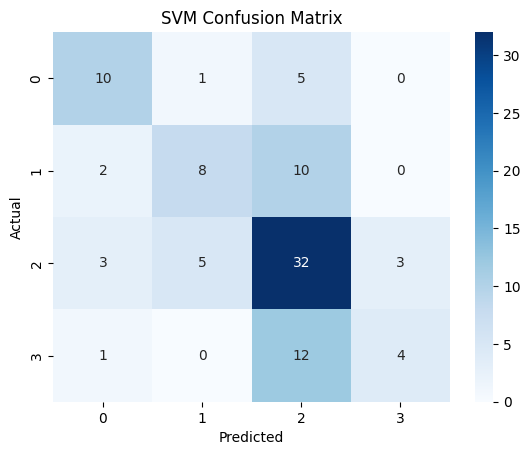

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.25      0.32        16
           1       0.40      0.20      0.27        20
           2       0.49      0.81      0.61        43
           3       0.67      0.24      0.35        17

    accuracy                           0.49        96
   macro avg       0.50      0.37      0.39        96
weighted avg       0.50      0.49      0.45        96



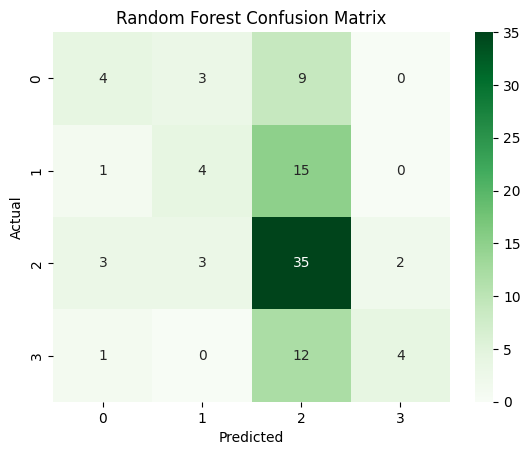

Sentences misclassified by both classifiers:
Common Misclassified Sentence 1: After hacking state TV by replacing propaganda images with real ones they directly addressed Putin's "Against us you cannot win" and the soldiers on the front lines with a call to lay down their weapons. Today you can fight a war without firing a shot. Respect
-
Common Misclassified Sentence 2: Fourth. Earlier this week, thousands of social media users falsely claimed that this video showed the war between Russia and Ukraine, but it is a video of the video game "Weapon 3" always channel Scarlett Fidanza
-
Common Misclassified Sentence 3: Ukraine as seen from the web: wartime videos, photos and messages
-
Common Misclassified Sentence 4: Ukraine-Russia war, Zelensky: "Never ordered surrender" - Video: (Adnkronos) - New video of Ukrainian president: "I'm here. We will not lay down our arms."
-
Common Misclassified Sentence 5: #news #sicily
War in Ukraine, woman challenges Russian soldier, "you will soon be a fe

In [24]:


nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

# Load dataset
data = pd.read_csv("/kaggle/input/filtered-and-translated-nlp/filr.csv")

# Extract relevant columns
texts = data["Translated"].astype(str).tolist()
labels = data["Label"].tolist()

# Tokenize sentences
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Load GloVe embeddings
glove_path = "/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt"  # Adjust path
glove_embeddings = {}

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector

# Function to get sentence embeddings
def get_sentence_embedding(sentence_tokens, embedding_dim=200):
    vectors = [glove_embeddings[word] for word in sentence_tokens if word in glove_embeddings]
    return np.mean(vectors, axis=0) if vectors else np.zeros(embedding_dim)

# Convert texts to GloVe-based embeddings
X_glove = np.array([get_sentence_embedding(tokens) for tokens in tokenized_texts])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_glove, labels, test_size=0.2, random_state=42)

# Train classifiers
svm_classifier = SVC(kernel="linear")
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

svm_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_classifier.predict(X_test)
y_pred_rf = random_forest_classifier.predict(X_test)

# Classification Reports & Confusion Matrices
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

# ==========================
# ✅ POS Tagging & Misclassification Analysis
# ==========================

# POS tagging of original sentences
pos_tagged_texts = [pos_tag(word_tokenize(text.lower())) for text in texts]

# Identify misclassified samples
misclassified_indices_svm = np.where(y_pred_svm != y_test)[0]
misclassified_indices_rf = np.where(y_pred_rf != y_test)[0]

misclassified_texts_svm = [texts[i] for i in misclassified_indices_svm]
misclassified_texts_rf = [texts[i] for i in misclassified_indices_rf]

misclassified_pos_svm = [pos_tagged_texts[i] for i in misclassified_indices_svm]
misclassified_pos_rf = [pos_tagged_texts[i] for i in misclassified_indices_rf]

# Identify sentences misclassified by both classifiers
common_misclassified_indices = set(misclassified_indices_svm) & set(misclassified_indices_rf)
common_misclassified_texts = [texts[i] for i in common_misclassified_indices]

print("Sentences misclassified by both classifiers:")
for idx, sentence in enumerate(common_misclassified_texts[:10]):  # Show top 10
    print(f"Common Misclassified Sentence {idx+1}: {sentence}")
    print("-")

# Suggesting changes to POS tagging for better classification
def suggest_pos_changes(sentence_tokens):
    """Suggest modifications to POS tagging to improve classification"""
    modified_tokens = []
    for word, tag in sentence_tokens:
        if tag in ["NN", "NNS"]:  # Nouns
            modified_tokens.append((word, "NN"))
        elif tag in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]:  # Verbs
            modified_tokens.append((word, "VB"))
        elif tag in ["JJ", "JJR", "JJS"]:  # Adjectives
            modified_tokens.append((word, "JJ"))
        else:
            modified_tokens.append((word, tag))
    return modified_tokens

# Applying suggested modifications
suggested_pos_svm = [suggest_pos_changes(pos) for pos in misclassified_pos_svm]
suggested_pos_rf = [suggest_pos_changes(pos) for pos in misclassified_pos_rf]

# Display suggested POS modifications
print("Suggested POS Tagging Modifications for SVM Misclassified Sentences:")
for idx, suggested in enumerate(suggested_pos_svm[:10]):  # Show top 10
    print(f"Modified SVM Misclassified Sentence {idx+1} POS Tags:", suggested)
    print("-")

print("Suggested POS Tagging Modifications for RF Misclassified Sentences:")
for idx, suggested in enumerate(suggested_pos_rf[:10]):  # Show top 10
    print(f"Modified RF Misclassified Sentence {idx+1} POS Tags:", suggested)
    print("-")


# CNN

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        20
           2       0.45      1.00      0.62        43
           3       0.00      0.00      0.00        17

    accuracy                           0.45        96
   macro avg       0.11      0.25      0.15        96
weighted avg       0.20      0.45      0.28        96



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


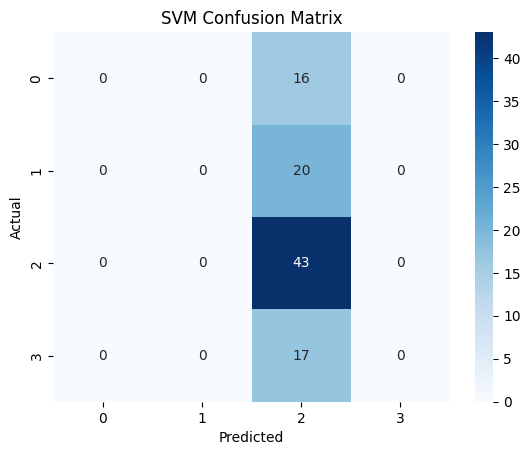

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.20      0.05      0.08        20
           2       0.44      0.91      0.59        43
           3       1.00      0.06      0.11        17

    accuracy                           0.43        96
   macro avg       0.41      0.25      0.20        96
weighted avg       0.42      0.43      0.30        96



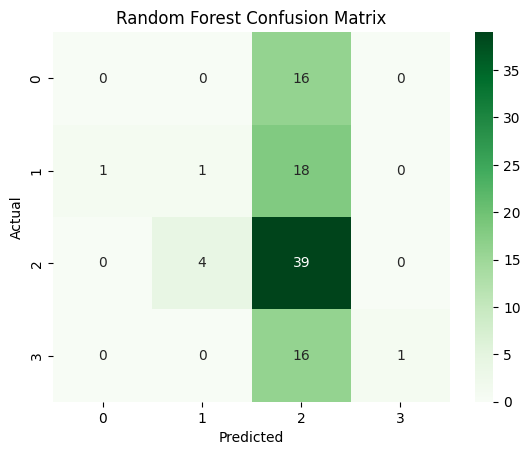

Sentences misclassified by both classifiers:
Common Misclassified Sentence 1: After hacking state TV by replacing propaganda images with real ones they directly addressed Putin's "Against us you cannot win" and the soldiers on the front lines with a call to lay down their weapons. Today you can fight a war without firing a shot. Respect
-
Common Misclassified Sentence 2: If only we all showed more love and understanding maybe we would not need to fight wars with bombs and weapons.

As much as you can have a good Sunday, all our thoughts are with the Ukrainian people. 🙏❤️
#PACE #NoWar
#goodmorning #CanYaman
-
Common Misclassified Sentence 3: War in Ukraine: battle in the streets of Kiev. Zelensky's appeal: "Let's defend the capital, weapons are coming." | Live, video and photos #Ukraine #russia #war #kiev #dead #injured #Ukraine #putin #RussiaUkraineConflict
-
Common Misclassified Sentence 4: Fourth. Earlier this week, thousands of social media users falsely claimed that this video show

In [18]:


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Load dataset
data = pd.read_csv("/kaggle/input/filtered-and-translated-nlp/filr.csv")

# Extract relevant columns
texts = data["Translated"].astype(str).tolist()
labels = data["Label"].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_length = max(len(seq) for seq in sequences)
X_padded = pad_sequences(sequences, maxlen=max_length, padding='post')

# POS Tagging
tokenized_texts = [word_tokenize(text.lower()) for text in texts]
pos_tagged_texts = [pos_tag(tokens) for tokens in tokenized_texts]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# ---------- CNN Model for Feature Extraction ----------
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100)(input_layer)
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)

# Feature extractor model
feature_extractor = Model(inputs=input_layer, outputs=pooling_layer)

# Extract Features using CNN
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# ---------- Train SVM & Random Forest ----------
svm_classifier = SVC(kernel='linear')
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

svm_classifier.fit(X_train_features, y_train)
random_forest_classifier.fit(X_train_features, y_train)

# Predictions
y_pred_svm = svm_classifier.predict(X_test_features)
y_pred_rf = random_forest_classifier.predict(X_test_features)

# Classification Reports & Confusion Matrices
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Identify misclassified samples
misclassified_indices_svm = np.where(y_pred_svm != y_test)[0]
misclassified_indices_rf = np.where(y_pred_rf != y_test)[0]
misclassified_texts_svm = [texts[i] for i in misclassified_indices_svm]
misclassified_texts_rf = [texts[i] for i in misclassified_indices_rf]
misclassified_pos_svm = [pos_tagged_texts[i] for i in misclassified_indices_svm]
misclassified_pos_rf = [pos_tagged_texts[i] for i in misclassified_indices_rf]

# Identify sentences misclassified by both classifiers
common_misclassified_indices = set(misclassified_indices_svm) & set(misclassified_indices_rf)
common_misclassified_texts = [texts[i] for i in common_misclassified_indices]

print("Sentences misclassified by both classifiers:")
for idx, sentence in enumerate(common_misclassified_texts):
    print(f"Common Misclassified Sentence {idx+1}: {sentence}")
    print("-")

# Suggesting changes to POS tagging for correct classification
def suggest_pos_changes(sentence_tokens):
    """Suggest modifications to POS tagging to improve classification"""
    modified_tokens = []
    for word, tag in sentence_tokens:
        if tag in ["NN", "NNS"]:  # Nouns
            modified_tokens.append((word, "NN"))
        elif tag in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]:  # Verbs
            modified_tokens.append((word, "VB"))
        elif tag in ["JJ", "JJR", "JJS"]:  # Adjectives
            modified_tokens.append((word, "JJ"))
        else:
            modified_tokens.append((word, tag))
    return modified_tokens

# Applying suggestions for corrections
suggested_pos_svm = [suggest_pos_changes(pos) for pos in misclassified_pos_svm]
suggested_pos_rf = [suggest_pos_changes(pos) for pos in misclassified_pos_rf]

# Display suggested POS tag modifications
print("Suggested POS Tagging Modifications for SVM Misclassified Sentences:")
for idx, suggested in enumerate(suggested_pos_svm[:10]):
    print(f"Modified SVM Misclassified Sentence {idx+1} POS Tags:", suggested)
    print("-")

print("Suggested POS Tagging Modifications for RF Misclassified Sentences:")
for idx, suggested in enumerate(suggested_pos_rf[:10]):
    print(f"Modified RF Misclassified Sentence {idx+1} POS Tags:", suggested)
    print("-")


# LDA

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.31      0.20      0.24        20
           2       0.47      0.91      0.62        43
           3       0.00      0.00      0.00        17

    accuracy                           0.45        96
   macro avg       0.19      0.28      0.22        96
weighted avg       0.27      0.45      0.33        96



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


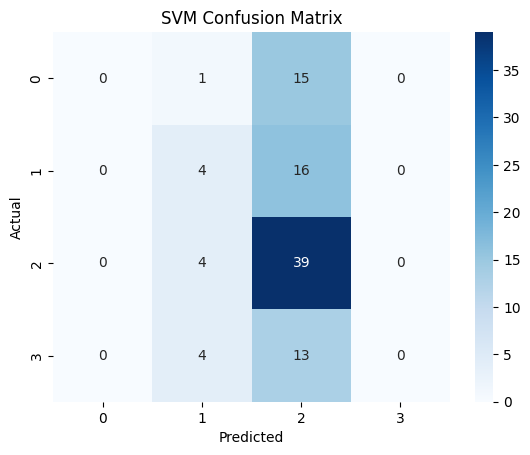

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.12      0.14        16
           1       0.23      0.35      0.28        20
           2       0.56      0.58      0.57        43
           3       0.25      0.12      0.16        17

    accuracy                           0.38        96
   macro avg       0.30      0.29      0.29        96
weighted avg       0.37      0.38      0.36        96



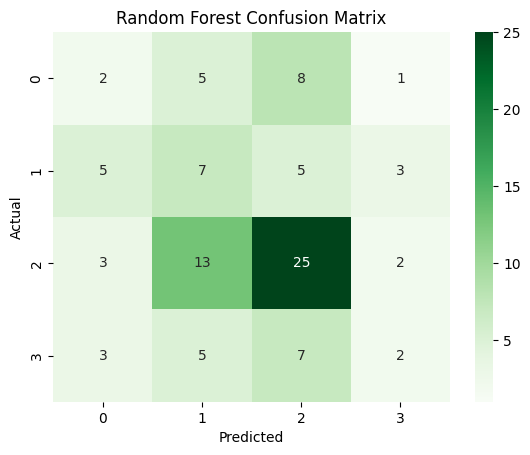

Sentences misclassified by both classifiers:
Common Misclassified Sentence 1: After hacking state TV by replacing propaganda images with real ones they directly addressed Putin's "Against us you cannot win" and the soldiers on the front lines with a call to lay down their weapons. Today you can fight a war without firing a shot. Respect
-
Common Misclassified Sentence 2: If only we all showed more love and understanding maybe we would not need to fight wars with bombs and weapons.

As much as you can have a good Sunday, all our thoughts are with the Ukrainian people. 🙏❤️
#PACE #NoWar
#goodmorning #CanYaman
-
Common Misclassified Sentence 3: War in Ukraine: battle in the streets of Kiev. Zelensky's appeal: "Let's defend the capital, weapons are coming." | Live, video and photos #Ukraine #russia #war #kiev #dead #injured #Ukraine #putin #RussiaUkraineConflict
-
Common Misclassified Sentence 4: Ukraine-Russia war, weapons to civilians in Kiev - Video
-
Common Misclassified Sentence 5: Fou

In [19]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Load dataset
data = pd.read_csv("/kaggle/input/filtered-and-translated-nlp/filr.csv")

# Extract relevant columns
texts = data["Translated"].astype(str).tolist()
labels = data["Label"].tolist()

# Tokenization
tokenized_texts = [" ".join(word_tokenize(text.lower())) for text in texts]

# POS Tagging
pos_tagged_texts = [pos_tag(word_tokenize(text.lower())) for text in texts]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Convert text to document-term matrix for LDA
vectorizer = CountVectorizer(max_features=5000, stop_words="english")
X_bow = vectorizer.fit_transform(tokenized_texts)

# LDA Model for Feature Extraction
num_topics = 20  # Define the number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
X_lda = lda_model.fit_transform(X_bow)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_lda, y_encoded, test_size=0.2, random_state=42)

# ---------- Train SVM & Random Forest ----------
svm_classifier = SVC(kernel='linear')
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

svm_classifier.fit(X_train, y_train)
random_forest_classifier.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_classifier.predict(X_test)
y_pred_rf = random_forest_classifier.predict(X_test)

# Classification Reports & Confusion Matrices
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Identify misclassified samples
misclassified_indices_svm = np.where(y_pred_svm != y_test)[0]
misclassified_indices_rf = np.where(y_pred_rf != y_test)[0]
misclassified_texts_svm = [texts[i] for i in misclassified_indices_svm]
misclassified_texts_rf = [texts[i] for i in misclassified_indices_rf]
misclassified_pos_svm = [pos_tagged_texts[i] for i in misclassified_indices_svm]
misclassified_pos_rf = [pos_tagged_texts[i] for i in misclassified_indices_rf]

# Identify sentences misclassified by both classifiers
common_misclassified_indices = set(misclassified_indices_svm) & set(misclassified_indices_rf)
common_misclassified_texts = [texts[i] for i in common_misclassified_indices]

print("Sentences misclassified by both classifiers:")
for idx, sentence in enumerate(common_misclassified_texts):
    print(f"Common Misclassified Sentence {idx+1}: {sentence}")
    print("-")

# Suggesting changes to POS tagging for correct classification
def suggest_pos_changes(sentence_tokens):
    """Suggest modifications to POS tagging to improve classification"""
    modified_tokens = []
    for word, tag in sentence_tokens:
        if tag in ["NN", "NNS"]:  # Nouns
            modified_tokens.append((word, "NN"))
        elif tag in ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"]:  # Verbs
            modified_tokens.append((word, "VB"))
        elif tag in ["JJ", "JJR", "JJS"]:  # Adjectives
            modified_tokens.append((word, "JJ"))
        else:
            modified_tokens.append((word, tag))
    return modified_tokens

# Applying suggestions for corrections
suggested_pos_svm = [suggest_pos_changes(pos) for pos in misclassified_pos_svm]
suggested_pos_rf = [suggest_pos_changes(pos) for pos in misclassified_pos_rf]

# Display suggested POS tag modifications
print("Suggested POS Tagging Modifications for SVM Misclassified Sentences:")
for idx, suggested in enumerate(suggested_pos_svm[:10]):
    print(f"Modified SVM Misclassified Sentence {idx+1} POS Tags:", suggested)
    print("-")

print("Suggested POS Tagging Modifications for RF Misclassified Sentences:")
for idx, suggested in enumerate(suggested_pos_rf[:10]):
    print(f"Modified RF Misclassified Sentence {idx+1} POS Tags:", suggested)
    print("-")
